In [137]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import random
from scipy.stats import norm

random.seed(42)

if len(sys.argv) != 3 and 0:
    print('Usage: python autocorrelation.py <json_file> <stat>')
    sys.exit(1)

json_file = "../simulations/results/DataAnalysis_p_0.5_interDeparture.json" # sys.argv[1]

f = open(json_file, 'r')
data = json.load(f)

print("data loaded")


data loaded


In [140]:

import numpy as np

stat = 'taskTimeStat:vector'  #sys.argv[2]
# taskTimeStat:vector
# cloudNodeStatInterDepartureTime:vector

repetitions_original = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for repetition in data:
    for vector in data[repetition]['vectors']:
        if vector['name'] != stat:
            continue
        
        #if data[repetition]['itervars']['distr'] != '1' or data[repetition]['itervars']['fairSharing'] != 'true':
        #    continue
        distr = data[repetition]['itervars']['distr']
        fairshare = data[repetition]['itervars']['fairSharing']
        N = int(data[repetition]['itervars']['N'])
        repetitions_original[distr][fairshare][N] = vector['value']
        break

print("repetitions loaded")


repetitions loaded


In [22]:
a = list(repetitions_original['0']['true'].keys())
a.sort()
a

['1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [24]:
alpha = 0.05

repetitions_sampled = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for distr in repetitions_original:
    for fairshare in repetitions_original[distr]:
        repetitions = repetitions_original[distr][fairshare]
        p = [1.5 for i in range(len(repetitions))]
        autocorrelated = [True for i in range(len(repetitions))]
        for rep in range(100, 0, -1):
            rep_0 = rep-1

            while autocorrelated[rep_0]:
                p[rep_0] /= 1.5

                if p[rep_0] < 2**(-15):
                    exit(f"error at {rep}")

                samples = []
                for s in repetitions[rep]:
                    if random.random() < p[rep_0]:
                        samples.append(s)

                print(rep, 'p:', p[rep_0])
                print('Original samples:', len(repetitions[rep]))
                print('Samples:', len(samples))

                autocorrelation = []

                X_avg = sum(samples) / len(samples)
                S2 = sum([(x - X_avg) ** 2 for x in samples]) / (len(samples) - 1)

                for i in range(1, min(100, len(samples)//5)):
                    sum_ = 0
                    for j in range(len(samples) - i):
                        sum_ += (samples[j] - X_avg) * (samples[j + i] - X_avg)
                    autocorrelation.append(sum_ / ((len(samples) - i) * S2))

                z = norm.ppf(1 - alpha/2)
                confidence = z / (len(samples) ** 0.5)

                out_of_bounds = 0
                outliers = 0
                
                for i in range(len(autocorrelation)):
                    if abs(autocorrelation[i]) > confidence:
                        out_of_bounds += 1
                        outliers += abs(autocorrelation[i])-confidence

                if out_of_bounds < len(autocorrelation) * alpha * 1.3 and outliers < confidence:
                    autocorrelated[rep_0] = False
                    repetitions_sampled[distr][fairshare][rep] = samples

                # plot autocorrelation and confidence interval
                #plt.plot(autocorrelation)
                #plt.axhline(confidence, color='r', linestyle='dashed')
                #plt.axhline(-confidence, color='r', linestyle='dashed')
                #plt.show()

#print(autocorrelated)
#print(p)
#[print(1/p[i]) for i in range(len(p))]




100 p: 1.0
Original samples: 99600
Samples: 99600
100 p: 0.6666666666666666
Original samples: 99600
Samples: 66320
100 p: 0.4444444444444444
Original samples: 99600
Samples: 44182
100 p: 0.2962962962962963
Original samples: 99600
Samples: 29578
100 p: 0.19753086419753085
Original samples: 99600
Samples: 19504
99 p: 1.0
Original samples: 99600
Samples: 99600
99 p: 0.6666666666666666
Original samples: 99600
Samples: 66593
98 p: 1.0
Original samples: 99600
Samples: 99600
98 p: 0.6666666666666666
Original samples: 99600
Samples: 66563
98 p: 0.4444444444444444
Original samples: 99600
Samples: 44037
97 p: 1.0
Original samples: 99600
Samples: 99600
97 p: 0.6666666666666666
Original samples: 99600
Samples: 66105
96 p: 1.0
Original samples: 99600
Samples: 99600
96 p: 0.6666666666666666
Original samples: 99600
Samples: 66461
95 p: 1.0
Original samples: 99600
Samples: 99600
95 p: 0.6666666666666666
Original samples: 99600
Samples: 66312
94 p: 1.0
Original samples: 99600
Samples: 99600
94 p: 0.666

In [90]:
# save repetitions_sampled to json
with open('repetitions_sampled.json', 'w') as f:
    json.dump(repetitions_sampled, f)

# save repetitions_original to json
with open('repetitions_original.json', 'w') as f:
    json.dump(repetitions_original, f)



In [92]:
# reload the json files
with open('repetitions_sampled.json', 'r') as f:
    repetitions_sampled_sbagliato = json.load(f)

repetitions_sampled = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for distr in repetitions_sampled_sbagliato:
    for fairshare in repetitions_sampled_sbagliato[distr]:
        for n in repetitions_sampled_sbagliato[distr][fairshare]:
            repetitions_sampled[distr][fairshare][int(n)] = repetitions_sampled_sbagliato[distr][fairshare][n]

print(repetitions_sampled['1']['true'][1][:10])

[3.635981813413, 11.419899778465, 6.737459381481, 3.970980976589, 25.183660992039, 0.341201405089, 5.384636449202, 1.726720714329, 0.183263998151, 8.589920387016]


In [33]:
# Plot variance with respect to the number of samples (to check if the variance converges to a value)


def check_variance_convergence(original_samples, show_plot=False):
    sample_sizes = range(100, len(original_samples) + 1, len(original_samples)//100)  # Increase sample size by 10 each step
    variances = []


    random.seed(42)
    #print(original_samples[:100])
    for size in sample_sizes:
        random_samples = random.sample(original_samples, size)
        variance = np.var(random_samples, ddof=1)  # Calculate variance with Bessel's correction
        #X_avg = sum(random_samples) / len(random_samples)
        #S2 = sum([(x - X_avg) ** 2 for x in random_samples]) / (len(random_samples) - 1)
        #variance = S2
        variances.append(variance)

    # Plot variance with respect to the number of samples
    # plot only dots
    if show_plot:
        plt.plot(sample_sizes, variances, 'o')
        plt.xlabel('Number of Samples')
        plt.ylabel('Variance')
        plt.title('Variance vs. Number of Samples')
        plt.ylim(bottom=0)
        plt.grid(True)
        plt.show()

    # Check if variances vector seems converging
    def check_convergence_ratio(arr, window=50, tol=1e-1):
        arr = np.array(arr, dtype=np.float64)
        if len(arr) < window + 1:
            return "Inconcludente"

        # Calcola il rapporto tra termini successivi
        ratios = arr[1:] / (arr[:-1] + 1e-10)  # Evita divisioni per zero

        # Controlla la stabilità del rapporto negli ultimi "window" elementi
        recent_ratios = ratios[-window:]
        avg_ratio = np.mean(recent_ratios)
        
        #print(np.abs(recent_ratios - 1))

        if np.all(np.abs(recent_ratios - 1) < tol):
            return "Converge"
        elif avg_ratio > 1:
            return "Diverge"
        else:
            return "Decresce (possibile convergenza)"

    converging = check_convergence_ratio(variances)
    print("Variance is converging:", converging)
    return converging


# Choose increasing number of random samples from original samples
original_samples = repetitions_original['1']['true'][100]

import time

all_ok = True

# check for each repetition in repetitions_original
for distr in repetitions_original:
    for fairshare in repetitions_original[distr]:
        for N in repetitions_original[distr][fairshare]:
            print(f"Checking variance convergence for {distr} {fairshare} {N}")
            if check_variance_convergence(repetitions_original[distr][fairshare][N]) != "Converge":
                all_ok = False
            #time.sleep(1)

print("All ok:", all_ok)


Checking variance convergence for 0 true 59
Variance is converging: Converge
Checking variance convergence for 0 true 60
Variance is converging: Converge
Checking variance convergence for 0 true 61
Variance is converging: Converge
Checking variance convergence for 0 true 62
Variance is converging: Converge
Checking variance convergence for 0 true 63
Variance is converging: Converge
Checking variance convergence for 0 true 64
Variance is converging: Converge
Checking variance convergence for 0 true 65
Variance is converging: Converge
Checking variance convergence for 0 true 66
Variance is converging: Converge
Checking variance convergence for 0 true 67
Variance is converging: Converge
Checking variance convergence for 0 true 68
Variance is converging: Converge
Checking variance convergence for 0 true 69
Variance is converging: Converge
Checking variance convergence for 0 true 70
Variance is converging: Converge
Checking variance convergence for 0 true 71
Variance is converging: Converge

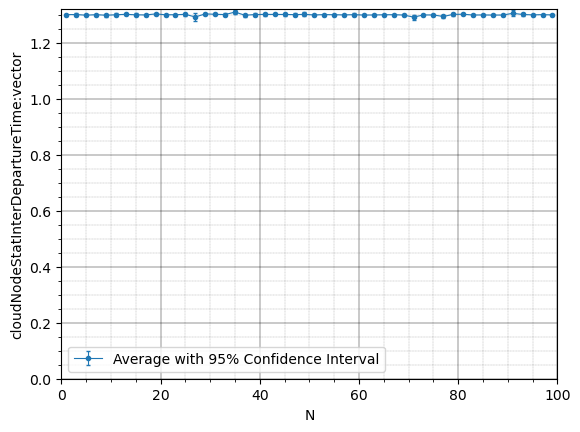

In [133]:
N = [i for i in range(1, len(repetitions_original['0']['true'])+1)]
average = []
confidence = []

alpha = 0.05
z = norm.ppf(1 - alpha/2)

repetitions = repetitions_sampled['0']['true']
for n in N:
    if len(repetitions[n]) <= 30:
        raise ValueError("Not enough samples")
    X = sum(repetitions[n]) / len(repetitions[n])
    S = (sum([(x - X) ** 2 for x in repetitions[n]]) / (len(repetitions[n]) - 1)) ** 0.5

    average.append(X)
    confidence.append(z * S / (len(repetitions[n]) ** 0.5))

#plt.errorbar(N, average, yerr=confidence, fmt='o', capsize=2, capthick=1, markersize=3)
plt.errorbar(N[::2], np.array(average)[::2], yerr=np.array(confidence)[::2], fmt='o', capsize=1.7, capthick=1
            , markersize=3, elinewidth=0.8, linestyle='-', linewidth=0.8)
plt.xlabel('N')
plt.ylabel(stat)

#set y to staecolor=''rt at 0
plt.ylim(bottom=0)
plt.xlim(left=0, right=100)

plt.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
plt.legend(['Average with 95% Confidence Interval'])
plt.show()

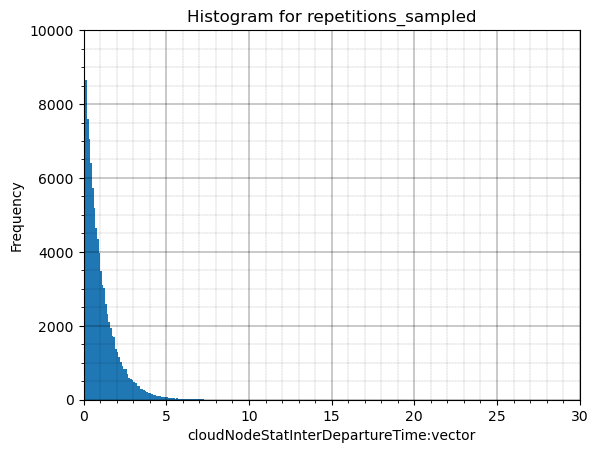

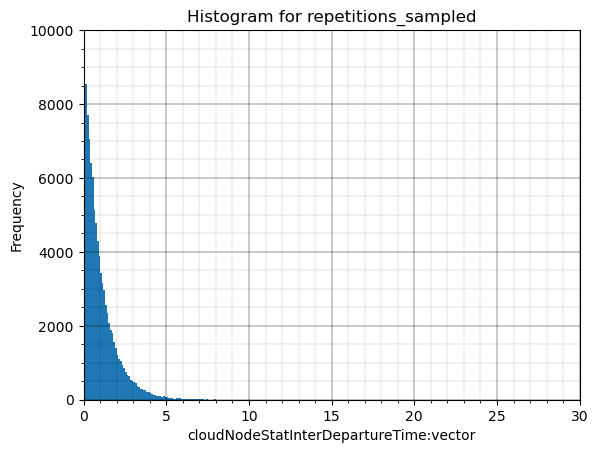

In [ ]:
# Plot histogram for repetitions_sampled['1']['false'][10]
repetitions = repetitions_original['1']['true'][1]
# make bins of size 0.01
plt.hist(repetitions, bins=np.arange(0, max(repetitions) + 0.1, 0.1))
plt.xlabel(stat)
plt.ylabel('Frequency')
plt.title('Histogram for repetitions_sampled')
plt.xlim(left=0, right=30)
plt.ylim(bottom=0, top=10000)
plt.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
plt.show()

# Plot histogram for repetitions_sampled['1']['false'][10]
repetitions = repetitions_original['1']['true'][10]
plt.hist(repetitions, bins=np.arange(0, max(repetitions) + 0.1, 0.1))
plt.xlabel(stat)
plt.ylabel('Frequency')
plt.title('Histogram for repetitions_sampled')
plt.xlim(left=0, right=30)
plt.ylim(bottom=0, top=10000)
plt.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
plt.show()

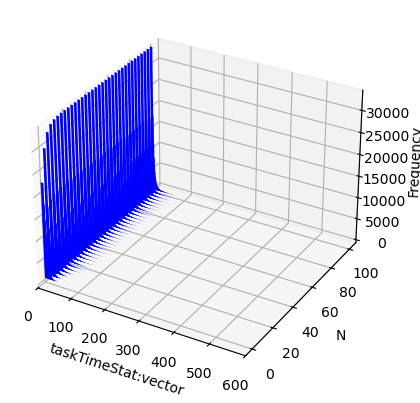

In [202]:
from mpl_toolkits.mplot3d import Axes3D

# plot distribution of the original samples

repetitions = repetitions_original['1']['true']

# make a 3D histogram for various N
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D histogram
for n in range(1, len(repetitions)+1, 3):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 601, 1))
    bins = 0.5 * (bins[:-1] + bins[1:])  # Convert bin edges to centers
    ax.bar(bins, hist, zs=n, zdir='y', alpha=1, label=f'N={n}', width=8, color='b')
    # set x limits
    ax.set_xlim(0, 600)
    
ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
#plt.legend(loc='upper right')
plt.show()



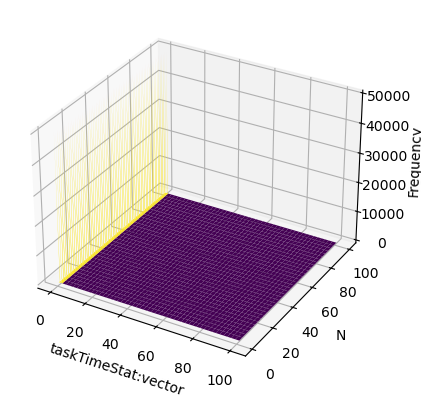

In [192]:

repetitions = repetitions_original['0']['true']

# Prepare data for surface plot
X, Y = np.meshgrid(np.arange(0, 101, 0.1), np.arange(1, len(repetitions)+1, 3))
Z = np.zeros_like(X, dtype=float)

for idx, n in enumerate(range(1, len(repetitions)+1, 3)):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 101.1, 0.1))
    Z[idx, :] = hist

# Plot surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
plt.show()


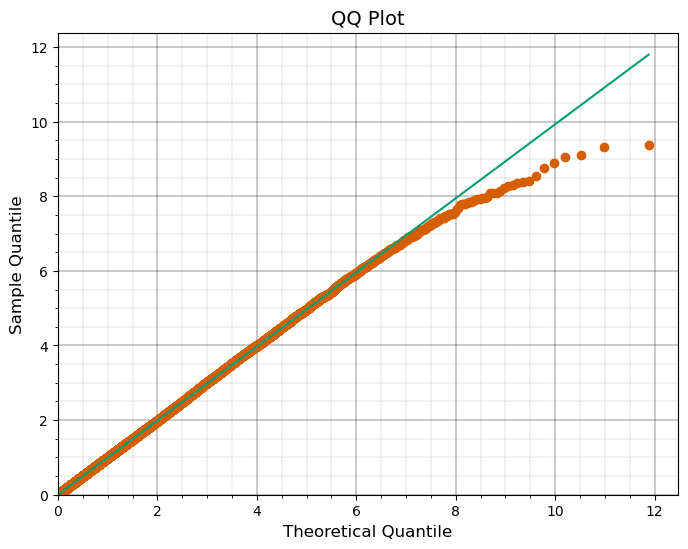

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unisci tutti i dati in una singola lista
all_data = repetitions_original['1']['true'][100]
#all_data = []
#for key in data:
#    all_data.extend(data[key])


# Converti i dati in un array di NumPy
all_data = np.array(all_data)

# Lista delle distribuzioni da testare
distributions = ['expon']

# Crea un QQ plot per ciascuna distribuzione
for distribution in distributions:
    plt.figure(figsize=(8, 6))
    stats.probplot(all_data, dist=distribution, plot=plt)
    plt.title(f"QQ Plot", fontsize=14)
    plt.xlabel('Theoretical Quantile', fontsize=12)
    plt.ylabel('Sample Quantile', fontsize=12)
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.xlim(0)
    plt.ylim(0)
    plt.gca().get_lines()[0].set_color('#e69f00')  # Set the color of the QQ plot line
    plt.gca().get_lines()[1].set_color('#0072b2')  # Set the color of the QQ plot line
    plt.gca().get_lines()[1].set_color('#009e73')  # Set the color of the QQ plot line
    plt.gca().get_lines()[0].set_color('#d55e00')  # Set the color of the QQ plot line
    plt.show()

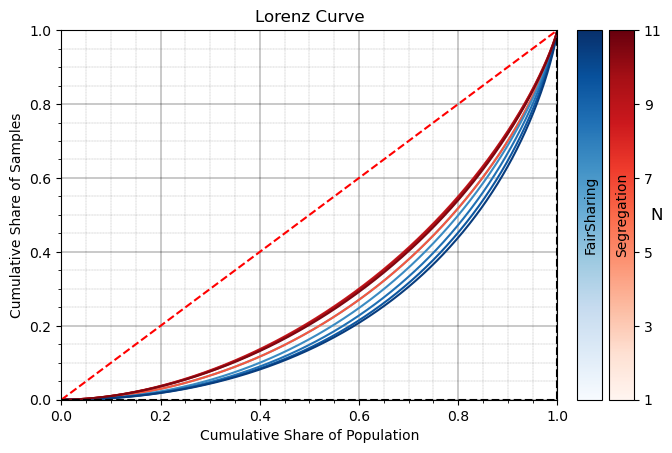

In [223]:


# Add colorbars for the legend
fig, ax = plt.subplots()
for n in range(1, 11, 2):
    samples_true = repetitions_original['1']['true'][n]
    samples_false = repetitions_original['1']['false'][n]
    samples_sorted_true = np.sort(samples_true)
    samples_sorted_false = np.sort(samples_false)
    cumulative_sum_true = np.cumsum(samples_sorted_true)
    cumulative_sum_false = np.cumsum(samples_sorted_false)
    cumulative_sum_normalized_true = cumulative_sum_true / cumulative_sum_true[-1]
    cumulative_sum_normalized_false = cumulative_sum_false / cumulative_sum_false[-1]
    population_share_true = np.arange(1, len(samples_true) + 1) / len(samples_true)
    population_share_false = np.arange(1, len(samples_false) + 1) / len(samples_false)
    ax.plot(population_share_true, cumulative_sum_normalized_true, label=f'Lorenz Curve True N={n}', color=plt.cm.Blues((n+10) / 20))
    ax.plot(population_share_false, cumulative_sum_normalized_false, label=f'Lorenz Curve False N={n}', color=plt.cm.Reds((n+10) / 20))

ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Line of Equality')
ax.plot([0, 1, 1], [0, 0, 1], linestyle='--', color='black', label='Line of Maximum Unfairness')
ax.set_xlabel('Cumulative Share of Population')
ax.set_ylabel('Cumulative Share of Samples')
ax.set_title('Lorenz Curve')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.3', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

# Create new axes for colorbars
cax_true = fig.add_axes([0.93, 0.11, 0.04, 0.77])
cax_false = fig.add_axes([0.98, 0.11, 0.04, 0.77])

sm_true = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=1, vmax=11))
sm_true.set_array([])
cbar_true = plt.colorbar(sm_true, cax=cax_true, ticks=[])
cbar_true.set_label('FairSharing', labelpad=-13.5)

sm_false = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=1, vmax=11))
sm_false.set_array([])
cbar_false = plt.colorbar(sm_false, cax=cax_false, ticks=np.linspace(1, 11, 6))
cbar_false.set_label('Segregation', labelpad=-33.5)
#cbar_false.set_label('N', labelpad=0)

# add text to the plot
ax.text(1.2, 0.5, 'N', fontsize=12, color='black', ha='center', va='center')

plt.show()